In [ ]:
from IPython.display import HTML
HTML('<style>body{font-family:"Roboto Condensed Light","Roboto Condensed";font-size:15px;}h1,h2{padding:10px 12px;background:#E64626;color:#fff;font-size:40px;margin:0;}h3{padding:10px 12px;background:#0148A4;color:#fff;font-size:20px;margin:0;}h4{padding:8px;font-family:"Roboto Condensed Light";font-style:italic;background:#FFB800;color:#fff;font-size:18px;text-align:center;border-radius:5px;margin:0;}h4:before{content:"@";font-family:"Wingdings";margin-right:4px;}p{font-size:15px;margin:0 0 1em;}input[type=submit]{background:#E64626;border:1px solid #734036;color:#fff;padding:8px 16px;margin:4px 2px;cursor:pointer;border-radius:20px;} </style>')



## DATA CLEANING & LOADING

In [20]:
!pip3 install numpy
!pip3 install pandas
!pip3 install geopandas
!pip3 install seaborn
!pip3 install matplotlib
!pip3 install plotly
!pip3 install geoalchemy2
!pip3 install shapely


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: pip install --upgrade pip
  Using cached geopandas-1.1.1-py3-none-any.whl.metadata (2.3 kB)
  Using cached certifi-2025.8.3-py3-none-any.whl.metadata (2.4 kB)
Using cached geopandas-1.1.1-py3-none-any.whl (338 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 4.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 6.0 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 62.6 MB/s eta 0:00:00
Using cached certifi-2025.8.3-py3-none-any.whl (161 kB)

[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: pip install --upgrade pip
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.

In [21]:
'''
Import necessary library
'''
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from geoalchemy2 import Geometry, WKTElement
from shapely.geometry import Point, Polygon, MultiPolygon


### 1. SA2 Boundaries DataFrame

In [22]:
'''
Defines a function to convert geometries to WKT format with SRID 4326, converting Polygons to MultiPolygons if needed.
'''

def create_wkt_element(geom, srid):
    if geom is None:
        return None
    if geom.geom_type == 'Polygon':
        geom = MultiPolygon([geom])
    return WKTElement(geom.wkt, srid)

srid = 4326

In [23]:
'''
Loads SA2 shapefile, filters for Greater Sydney, and keeps relevant geographic columns.
'''
gdf_sa2 = gpd.read_file("Datasets/SA2_2021_AUST_SHP_GDA2020/SA2_2021_AUST_GDA2020.shp")
    
gdf_greater_sydney = gdf_sa2[gdf_sa2['GCC_NAME21'] == 'Greater Sydney']

gdf_greater_sydney = gdf_greater_sydney[["SA2_CODE21", "SA2_NAME21", "SA4_CODE21", "SA4_NAME21", "AREASQKM21", "geometry"]]


In [24]:
'''
Checks for missing values, data types, geometry validity, and whether SA2/SA4 codes are numeric.
'''

#Check for missing values
print(gdf_greater_sydney.isnull().sum())

#Check data types
print(gdf_greater_sydney.dtypes)

#Check for invalid geometries
print(f" Invalid geometries (True/False): {gdf_greater_sydney.is_valid.value_counts()}")

#Check for numeric|
print(gdf_greater_sydney["SA2_CODE21"].str.isnumeric().sum())
print(gdf_greater_sydney["SA4_CODE21"].str.isnumeric().sum())

SA2_CODE21    0
SA2_NAME21    0
SA4_CODE21    0
SA4_NAME21    0
AREASQKM21    0
geometry      0
dtype: int64
SA2_CODE21      object
SA2_NAME21      object
SA4_CODE21      object
SA4_NAME21      object
AREASQKM21     float64
geometry      geometry
dtype: object
 Invalid geometries (True/False): True    373
Name: count, dtype: int64
373
373


In [25]:
'''
Cleaning Data:
Casts code columns to integers, renames columns to match DB schema, converts geometry to WKT, and saves valid SA2 codes for later filtering.
'''

#convert sa2_code21 and sa4_code21 to int
gdf_greater_sydney["SA2_CODE21"] = gdf_greater_sydney["SA2_CODE21"].astype(int)
gdf_greater_sydney["SA4_CODE21"] = gdf_greater_sydney["SA4_CODE21"].astype(int)

#renaming to match with postgre table
gdf_greater_sydney = gdf_greater_sydney.rename(columns={
    'SA2_CODE21': 'sa2_code',
    'SA2_NAME21': 'sa2_name',
    'SA4_CODE21': 'sa4_code',
    'SA4_NAME21': 'sa4_name',
    'AREASQKM21': 'areasqkm21'
})

gdf_filtered = gdf_greater_sydney.copy()

#converting to geom datat type
gdf_greater_sydney['geom'] = gdf_greater_sydney['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid)) 
gdf_greater_sydney = gdf_greater_sydney.drop(columns='geometry')
gdf_greater_sydney

#This set is used later on to check for valid sa2_code for child tables
valid_sa2_code = set(gdf_greater_sydney['sa2_code'])

### 2. Businesses DataFrame

In [26]:
'''
Load the business dataset.
'''

df_business = pd.read_csv("Datasets/Businesses.csv")
# Check missing values
print(df_business.isnull().sum())

# Check data types
print(df_business.dtypes)

industry_code             0
industry_name             0
sa2_code                  0
sa2_name                  0
0_to_50k_businesses       0
50k_to_200k_businesses    0
200k_to_2m_businesses     0
2m_to_5m_businesses       0
5m_to_10m_businesses      0
10m_or_more_businesses    0
total_businesses          0
dtype: int64
industry_code             object
industry_name             object
sa2_code                   int64
sa2_name                  object
0_to_50k_businesses        int64
50k_to_200k_businesses     int64
200k_to_2m_businesses      int64
2m_to_5m_businesses        int64
5m_to_10m_businesses       int64
10m_or_more_businesses     int64
total_businesses           int64
dtype: object


In [27]:
'''
Cleaning Data:
Keep necessary columns, and filters for valid SA2 codes.
'''

#keep necessary columns
df_business = df_business[["sa2_code", "sa2_name", "industry_code", "industry_name", "total_businesses"]]

#only keep valid sa2_codes correspond to the mother table gdf_greater_sydney
df_business = df_business[df_business['sa2_code'].isin(valid_sa2_code)]
df_business.head()


,sa2_code,sa2_name,industry_code,industry_name,total_businesses
28,102011028,Avoca Beach - Copacabana,A,"Agriculture, Forestry and Fishing",6
29,102011029,Box Head - MacMasters Beach,A,"Agriculture, Forestry and Fishing",17
30,102011030,Calga - Kulnura,A,"Agriculture, Forestry and Fishing",215
31,102011031,Erina - Green Point,A,"Agriculture, Forestry and Fishing",27
32,102011032,Gosford - Springfield,A,"Agriculture, Forestry and Fishing",19


### 3. Public Transport Stops DataFrame

In [28]:
'''
Load the stops dataset.
'''

df_stops = pd.read_csv("Datasets/Stops.txt")

#Check for null values and type.
print(df_stops.isnull().sum())
print(df_stops.dtypes)

stop_id                     0
stop_code               53999
stop_name                   0
stop_lat                    0
stop_lon                    0
location_type           60727
parent_station          53991
wheelchair_boarding         0
platform_code          113847
dtype: int64
stop_id                 object
stop_code              float64
stop_name               object
stop_lat               float64
stop_lon               float64
location_type          float64
parent_station          object
wheelchair_boarding      int64
platform_code           object
dtype: object


In [29]:
# Check for unique stop_ids
duplicates = df_stops[df_stops.duplicated('stop_id', keep=False)]
print(f"Number of duplicated stop_ids: {len(duplicates)}")

Number of duplicated stop_ids: 0


In [30]:
'''
Cleaning Data:
Converts geometry to WKT with SRID, keep necessary columns.
'''

#create geometry column
gdf_stops = gpd.GeoDataFrame(
    df_stops,
    geometry=gpd.points_from_xy(df_stops.stop_lon, df_stops.stop_lat)
)
gdf_stops['geom'] = gdf_stops['geometry'].apply(lambda x: WKTElement(x.wkt, srid=srid))  # creating the geometry column

# Select necessary columns
gdf_stops = gdf_stops[["stop_id", "stop_name", "geom"]]
gdf_stops

,stop_id,stop_name,geom
0,200039,"Central Station, Eddy Av, Stand A",POINT (151.20666465471 -33.8822064874687)
1,200054,"Central Station, Eddy Av, Stand D",POINT (151.20699145565 -33.8820421431408)
2,200060,Central Station,POINT (151.206292455081 -33.8840842535493)
3,201510,Redfern Station,POINT (151.198866071817 -33.8916900512711)
4,201646,"Redfern Station, Gibbons St, Stand B",POINT (151.198881722942 -33.8933293130144)
...,...,...,...
114713,212753,"Sydney Olympic Park Wharf, Side B",POINT (151.07879697831 -33.8220164586429)
114714,2137185,"Cabarita Wharf, Side A",POINT (151.116926480557 -33.8406690716775)
114715,2137186,"Cabarita Wharf, Side B",POINT (151.116898892402 -33.8407691073139)
114716,21501,Parramatta Wharf,POINT (151.010576673346 -33.8139042429414)


### 4. School Catchments DataFrame

In [31]:
'''
Load the catchment datasets and merge them together.
'''
gdf_primary = gpd.read_file("Datasets/catchments/catchments_primary.shp")
gdf_secondary = gpd.read_file("Datasets/catchments/catchments_secondary.shp")
gdf_future = gpd.read_file("Datasets/catchments/catchments_future.shp")

# Create a column to identify the school type
gdf_primary["Type"] = "Primary"
gdf_secondary["Type"] = "Secondary"
gdf_future["Type"] = "Future"

# Merge the separate tables into one
gdf_catchments = pd.concat([gdf_primary, gdf_secondary, gdf_future], ignore_index=True)

gdf_catchments.head()


,USE_ID,CATCH_TYPE,USE_DESC,ADD_DATE,KINDERGART,YEAR1,YEAR2,YEAR3,YEAR4,YEAR5,YEAR6,YEAR7,YEAR8,YEAR9,YEAR10,YEAR11,YEAR12,PRIORITY,geometry,Type
0,2838,PRIMARY,Parklea PS,20181210,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((150.93564 -33.71612, 150.93715 -33.7...",Primary
1,2404,PRIMARY,Lindfield EPS,20211219,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((151.18336 -33.74748, 151.18443 -33.7...",Primary
2,4393,PRIMARY,Carlingford WPS,20220223,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((151.04518 -33.77303, 151.04526 -33.7...",Primary
3,4615,PRIMARY,Caddies Ck PS,20181210,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((150.92567 -33.7296, 150.92602 -33.72...",Primary
4,3918,PRIMARY,Killara PS,20211219,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((151.15379 -33.75586, 151.15404 -33.7...",Primary


In [32]:
'''
Check for duplicated catchments.
'''
gdf_catchments[gdf_catchments.duplicated("USE_ID", keep = False)].sort_values("USE_ID")

,USE_ID,CATCH_TYPE,USE_DESC,ADD_DATE,KINDERGART,YEAR1,YEAR2,YEAR3,YEAR4,YEAR5,YEAR6,YEAR7,YEAR8,YEAR9,YEAR10,YEAR11,YEAR12,PRIORITY,geometry,Type
1176,1051,CENTRAL_PRIMARY,Ardlethan CS,20230228,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((146.99014 -34.14267, 146.99603 -34.1...",Primary
1910,1051,CENTRAL_HIGH,Ardlethan CS,20230228,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,"POLYGON ((146.99014 -34.14267, 146.99603 -34.1...",Secondary
1192,1055,CENTRAL_PRIMARY,Ariah Park CS,20230228,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((147.12135 -34.13669, 147.12024 -34.1...",Primary
1966,1055,CENTRAL_HIGH,Ariah Park CS,20230228,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,"POLYGON ((147.32523 -34.04334, 147.40429 -34.0...",Secondary
771,1066,CENTRAL_PRIMARY,Ashford CS,20190922,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((151.06592 -29.07396, 151.07472 -29.0...",Primary
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1793,8916,HIGH_COED,Oran Park HS,20200310,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,N,N,"POLYGON ((150.75452 -33.95472, 150.75653 -33.9...",Secondary
2115,8919,HIGH_COED,Bungendore HS,20220615,0,0,0,0,0,0,0,2024,2024,2024,2025,2026,2027,NaN,"POLYGON ((149.24085 -34.91439, 149.24367 -34.9...",Future
2042,8919,HIGH_COED,Bungendore HS,20230112,N,N,N,N,N,N,N,Y,Y,N,N,N,N,Y,"POLYGON ((149.24085 -34.91439, 149.24367 -34.9...",Secondary
2043,8922,HIGH_COED,Jerrabomberra HS,20230112,N,N,N,N,N,N,N,Y,Y,N,N,N,N,Y,"POLYGON ((149.206 -35.37104, 149.20764 -35.371...",Secondary


In [33]:
'''
Cleaning Data:
Renames school name column, converts geometry to WKT with SRID, and keeps only necessary columns.
'''

#rename school name column
gdf_catchments = gdf_catchments.rename(columns={"USE_DESC": "school_name"})  
gdf_catchments['geom'] = gdf_catchments['geometry'].apply(lambda x: WKTElement(x.wkt, srid=srid))  # creating the geometry column
# keep necessary columns
gdf_catchments = gdf_catchments[["USE_ID", "school_name", "Type", "geom"]]
gdf_catchments.head()

,USE_ID,school_name,Type,geom
0,2838,Parklea PS,Primary,POLYGON ((150.93563850416004 -33.7161211047945...
1,2404,Lindfield EPS,Primary,POLYGON ((151.1833640465581 -33.74748398847516...
2,4393,Carlingford WPS,Primary,POLYGON ((151.0451821055135 -33.77303212963235...
3,4615,Caddies Ck PS,Primary,POLYGON ((150.92567327976582 -33.7296030055687...
4,3918,Killara PS,Primary,POLYGON ((151.1537883781186 -33.75586174084874...


### 5. Population DataFrame

In [34]:
'''
Loads the population dataset.
'''

df_population = pd.read_csv("Datasets/Population.csv")
df_population.isnull().sum()
df_population.dtypes

sa2_code               int64
sa2_name              object
0-4_people             int64
5-9_people             int64
10-14_people           int64
15-19_people           int64
20-24_people           int64
25-29_people           int64
30-34_people           int64
35-39_people           int64
40-44_people           int64
45-49_people           int64
50-54_people           int64
55-59_people           int64
60-64_people           int64
65-69_people           int64
70-74_people           int64
75-79_people           int64
80-84_people           int64
85-and-over_people     int64
total_people           int64
dtype: object

In [35]:
'''
Cleaning Data:
Calculates young population (ages 0–19), renames columns, removes age breakdowns, and filters for valid SA2 codes.
'''

# Make a new column called young_population by combining 0-4, 5-9, 10-14, 15-19.
df_population.loc[:, "young_population"] = (
    df_population["0-4_people"] +
    df_population["5-9_people"] +
    df_population["10-14_people"] +
    df_population["15-19_people"]
)

df_population = df_population.rename(columns={"total_people": "total_population"})
df_population = df_population[["sa2_code", "sa2_name", "0-4_people", "5-9_people", "10-14_people", "15-19_people", "young_population", "total_population"]]

#remove redundant columns
drop_columns = ["0-4_people", "5-9_people", "10-14_people", "15-19_people"]
df_population = df_population.drop(columns=drop_columns)

#only keep valid sa2_codes correspond to the mother table gdf_greater_sydney
df_population = df_population[df_population['sa2_code'].isin(valid_sa2_code)]
df_population.head()

,sa2_code,sa2_name,young_population,total_population
0,102011028,Avoca Beach - Copacabana,2121,7530
1,102011029,Box Head - MacMasters Beach,2471,11052
2,102011030,Calga - Kulnura,961,4748
3,102011031,Erina - Green Point,3205,14803
4,102011032,Gosford - Springfield,4364,21346


### 6. Income DataFrame

In [36]:
'''
Loads the income dataset.
'''

df_income = pd.read_csv("Datasets/Income.csv")
df_income.isnull().sum()
df_income.dtypes

sa2_code21        int64
sa2_name         object
earners          object
median_age       object
median_income    object
mean_income      object
dtype: object

In [37]:
'''
Cleaning Data: 
Selects relevant columns, handles missing values, converts to numeric, and filters for valid SA2 codes.
'''

df_income = df_income[["sa2_code21", "sa2_name", "median_income"]]
df_income = df_income.rename(columns={
    'sa2_code21': 'sa2_code',
})
df_income["median_income"] = (df_income["median_income"].replace("np", pd.NA))
df_income["median_income"] = pd.to_numeric(df_income["median_income"], errors="coerce")

#only keep valid sa2_codes correspond to the mother table gdf_greater_sydney
df_income = df_income[df_income['sa2_code'].isin(valid_sa2_code)]
df_income.head()

,sa2_code,sa2_name,median_income
28,102011028,Avoca Beach - Copacabana,55065.0
29,102011029,Box Head - MacMasters Beach,51927.0
30,102011030,Calga - Kulnura,49168.0
31,102011031,Erina - Green Point,51905.0
32,102011032,Gosford - Springfield,54372.0


## DATA INGESTION

In [38]:
from sqlalchemy import create_engine, text
import psycopg2
import psycopg2.extras
import json
import os

credentials = "Credentials.json"

def pgconnect(credential_filepath, db_schema="public"):
    with open(credential_filepath) as f:
        db_conn_dict = json.load(f)
        host       = db_conn_dict['host']
        db_user    = db_conn_dict['user']
        db_pw      = db_conn_dict['password']
        default_db = db_conn_dict['user']
        port       = db_conn_dict['port']
        try:
            db = create_engine(f'postgresql+psycopg2://{db_user}:{db_pw}@{host}:{port}/{default_db}', echo=False)
            conn = db.connect()
            print('Connected successfully.')
        except Exception as e:
            print("Unable to connect to the database.")
            print(e)
            db, conn = None, None
        return db,conn

def query(conn, sqlcmd, args=None, df=True):
    result = pd.DataFrame() if df else None
    try:
        if df:
            result = pd.read_sql_query(sqlcmd, conn, params=args)
        else:
            result = conn.execute(text(sqlcmd), args).fetchall()
            result = result[0] if len(result) == 1 else result
    except Exception as e:
        print("Error encountered: ", e, sep='\n')
    return result

In [39]:
db, conn = pgconnect(credentials)

Connected successfully.


In [40]:
# Create a new schema called 'greater_sydney'
conn.execute(text("""
CREATE SCHEMA IF NOT EXISTS greater_sydney;
CREATE EXTENSION IF NOT EXISTS postgis;
SET search_path TO greater_sydney, public;"""))

### 1. Create Table Schema

In [41]:
conn.execute(text("""

-- sa2_boundaries

DROP TABLE IF EXISTS sa2_boundaries CASCADE;
CREATE TABLE sa2_boundaries (
    sa2_code INT PRIMARY KEY,
    sa2_name VARCHAR(100),
    sa4_code INT,
    sa4_name VARCHAR(100),
    areasqkm21 NUMERIC,
    geom GEOMETRY(MultiPolygon, 4326) 
);

-- businesses

DROP TABLE IF EXISTS businesses CASCADE;
CREATE TABLE businesses (
    sa2_code INT,
    sa2_name VARCHAR(100),
    industry_code VARCHAR(100),
    industry_name VARCHAR(100),
    total_businesses INT,
    foreign key (sa2_code) references sa2_boundaries(sa2_code)
);

-- stops

DROP TABLE IF EXISTS stops CASCADE;
CREATE TABLE stops (
    stop_id VARCHAR(100) PRIMARY KEY,
    stop_name VARCHAR(100),
    geom GEOMETRY(Point, 4326)
);

-- catchments -- primary keys are generated for identification

DROP TABLE IF EXISTS catchments CASCADE;
CREATE TABLE catchments (
    school_id serial primary key,
    school_name VARCHAR(100),
    type VARCHAR(50),
    geom GEOMETRY(MultiPolygon, 4326)
);

-- population

DROP TABLE IF EXISTS population CASCADE;
CREATE TABLE population (
    sa2_code INT PRIMARY KEY,
    sa2_name VARCHAR(100),
    total_population INT,
    young_population INT,
    foreign key (sa2_code) references sa2_boundaries(sa2_code)
);

-- income

DROP TABLE IF EXISTS income CASCADE;
CREATE TABLE income (
    sa2_code INT PRIMARY KEY,
    sa2_name VARCHAR(100),
    median_income NUMERIC,
    foreign key (sa2_code) references sa2_boundaries(sa2_code)
);

--sa2_pois
DROP TABLE IF EXISTS sa2_pois CASCADE;
CREATE TABLE sa2_pois (
    sa2_code INTEGER REFERENCES sa2_boundaries(sa2_code),
    sa2_name VARCHAR(100),
    id SERIAL PRIMARY KEY,
    topoid INTEGER,
    poigroup SMALLINT,
    poitype VARCHAR(50),
    poiname VARCHAR(200),
    lon DOUBLE PRECISION,
    lat DOUBLE PRECISION,
    geom GEOMETRY(Point, 4326)
);

"""))

conn.commit()


### 2. Data Ingestion

In [42]:
gdf_greater_sydney.to_sql("sa2_boundaries", con=conn, schema='greater_sydney', if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})
gdf_stops.to_sql("stops", con=conn, schema='greater_sydney', if_exists='append', index=False, dtype={'geom': Geometry('POINT', srid)})
gdf_catchments.to_sql("catchments", con=conn, schema='greater_sydney', if_exists='replace', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})

128

In [43]:
df_business.to_sql('businesses', con=conn, schema='greater_sydney', if_exists='append', index=False)
df_population.to_sql('population', con=conn, schema='greater_sydney', if_exists='append', index=False)
df_income.to_sql('income', con=conn, schema='greater_sydney', if_exists='append', index=False)


373

In [44]:
conn.commit()

In [45]:
query(conn, """
SELECT * FROM sa2_boundaries;
""")

,sa2_code,sa2_name,sa4_code,sa4_name,areasqkm21,geom
0,102011028,Avoca Beach - Copacabana,102,Central Coast,6.4376,0106000020E6100000010000000103000000010000005E...
1,102011029,Box Head - MacMasters Beach,102,Central Coast,32.0802,0106000020E61000000100000001030000000100000010...
2,102011030,Calga - Kulnura,102,Central Coast,767.9512,0106000020E61000000200000001030000000100000085...
3,102011031,Erina - Green Point,102,Central Coast,33.7934,0106000020E61000000100000001030000000100000041...
4,102011032,Gosford - Springfield,102,Central Coast,16.9123,0106000020E6100000010000000103000000010000007E...
...,...,...,...,...,...,...
368,128011531,Sylvania - Taren Point,128,Sydney - Sutherland,6.0595,0106000020E610000001000000010300000001000000F2...
369,128011602,Caringbah,128,Sydney - Sutherland,3.9959,0106000020E610000001000000010300000001000000EF...
370,128011603,Caringbah South,128,Sydney - Sutherland,4.0699,0106000020E610000001000000010300000001000000E9...
371,128021608,Loftus - Yarrawarrah,128,Sydney - Sutherland,3.8436,0106000020E610000001000000010300000001000000A1...


In [46]:
query(conn, """
SELECT * FROM stops LIMIT 5; """)

,stop_id,stop_name,geom
0,200039,"Central Station, Eddy Av, Stand A",0101000020E6100000FFA631FF9CE66240A1FF6524ECF0...
1,200054,"Central Station, Eddy Av, Stand D",0101000020E61000002F928BAC9FE66240E33DC7C1E6F0...
2,200060,Central Station,0101000020E6100000817FA2F299E662408FF33DAC29F1...
3,201510,Redfern Station,0101000020E61000009E57611C5DE6624060304CE622F2...
4,201646,"Redfern Station, Gibbons St, Stand B",0101000020E6100000DBF9333D5DE662403DFA6B9D58F2...


# API DATA COLLECTION

In [49]:
import json
import time
import requests
import time
from shapely.geometry import Point

In [50]:
'''
Function returns POIs knowing bounding box
'''
def pois_inside_bounding_box(xmin, ymin, xmax, ymax):
    baseURL = 'https://maps.six.nsw.gov.au/arcgis/rest/services/public/NSW_POI/MapServer/0/query'
    params = {
        'geometry': f'"xmin":{xmin},"ymin":{ymin},"xmax":{xmax},"ymax:{ymax}"',
        'outFields': '*',
        'returnGeometry': 'true',
        'f': 'json'
    }
    response = requests.get(baseURL, params)
    return json.loads(response.text)['features']

In [51]:
'''
Filter SA2 regions within the selected SA4 zones: 'Sydney - Parramatta' and 'Sydney - Eastern Suburbs'
'''

mask = (
    (gdf_filtered["sa4_name"] == 'Sydney - Parramatta') |
    (gdf_filtered["sa4_name"] == 'Sydney - Eastern Suburbs')
)

# select only those SA2 target
selected_sa2s = gdf_filtered.loc[mask]
sa2_pois = []

# for each selected_sa2 make a bounding box and request the pois within it.
for _, rows in selected_sa2s.iterrows():
    sa2_code = rows["sa2_code"]
    sa2_name = rows["sa2_name"]

    xmin, ymin, xmax, ymax = rows['geometry'].bounds
    pois = pois_inside_bounding_box(xmin, ymin, xmax, ymax)
    for poi in pois:
        attr = poi["attributes"]
        geom = poi["geometry"]
        
        poi_record = {
            "topoid": attr.get("topoid"),
            "poigroup": attr.get("poigroup"),
            "poitype": attr.get("poitype"),
            "poiname": attr.get("poiname"),
            "sa2_code": sa2_code,
            "sa2_name": sa2_name,
            "lon": geom.get("x"),
            "lat": geom.get("y"),
        }

        sa2_pois.append(poi_record)

    print(f"Added {len(pois)} POIs for SA2: {sa2_name} ({sa2_code})")
    time.sleep(1)

sa2_pois = pd.DataFrame(sa2_pois)


Added 80 POIs for SA2: Bondi - Tamarama - Bronte (118011339)
Added 78 POIs for SA2: Bondi Beach - North Bondi (118011340)
Added 106 POIs for SA2: Bondi Junction - Waverly (118011341)
Added 60 POIs for SA2: Centennial Park (118011342)
Added 55 POIs for SA2: Dover Heights (118011344)
Added 177 POIs for SA2: Paddington - Moore Park (118011345)
Added 233 POIs for SA2: Rose Bay - Vaucluse - Watsons Bay (118011346)
Added 59 POIs for SA2: Woollahra (118011347)
Added 117 POIs for SA2: Bellevue Hill (118011649)
Added 174 POIs for SA2: Double Bay - Darling Point (118011650)
Added 70 POIs for SA2: Kensington (NSW) (118021564)
Added 61 POIs for SA2: Kingsford (118021565)
Added 70 POIs for SA2: Maroubra - North (118021566)
Added 57 POIs for SA2: Maroubra - South (118021567)
Added 56 POIs for SA2: Maroubra - West (118021568)
Added 53 POIs for SA2: Randwick - North (118021569)
Added 139 POIs for SA2: Randwick - South (118021570)
Added 87 POIs for SA2: Coogee - Clovelly (118021651)
Added 210 POIs for 

In [52]:
'''
Creates Point geometries from latitude and longitude, then converts them to WKT format.
'''
sa2_pois['geom'] = gpd.points_from_xy(sa2_pois.lon, sa2_pois.lat)
sa2_pois['geom'] = sa2_pois['geom'].apply(lambda x: WKTElement(x.wkt, srid = 4326))
sa2_pois.head()

,topoid,poigroup,poitype,poiname,sa2_code,sa2_name,lon,lat,geom
0,500267049,3,Park,MARKS PARK,118011339,Bondi - Tamarama - Bronte,151.275150,-33.898499,POINT (151.2751497989923 -33.89849878686277)
1,500267060,1,Cemetery,WAVERLEY CEMETERY,118011339,Bondi - Tamarama - Bronte,151.266912,-33.908876,POINT (151.26691247511062 -33.90887602789484)
2,500267204,3,Park,HOGAN RESERVE,118011339,Bondi - Tamarama - Bronte,151.263143,-33.889041,POINT (151.26314284414116 -33.889040882839566)
3,500267504,1,Place Of Worship,THE CENTRAL SYNAGOGUE,118011339,Bondi - Tamarama - Bronte,151.256745,-33.890369,POINT (151.25674450729176 -33.89036896822749)
4,500267926,1,Post Office,BONDI BEACH POST OFFICE,118011339,Bondi - Tamarama - Bronte,151.272749,-33.890777,POINT (151.2727491106843 -33.890777169953466)


In [53]:
'''
Ingest sa2_pois DataFrame into local db
'''
sa2_pois.to_sql("sa2_pois", con=conn, if_exists="append", index=False, dtype={"geom": Geometry("POINT", srid=4326)})
conn.commit()
query(conn, """select * from sa2_pois; """)

,sa2_code,sa2_name,id,topoid,poigroup,poitype,poiname,lon,lat,geom
0,118011339,Bondi - Tamarama - Bronte,1,500267049,3,Park,MARKS PARK,151.275150,-33.898499,0101000020E61000008885F306CEE862401F891C0202F3...
1,118011339,Bondi - Tamarama - Bronte,2,500267060,1,Cemetery,WAVERLEY CEMETERY,151.266912,-33.908876,0101000020E6100000D3EF078C8AE862409FF6B70C56F4...
2,118011339,Bondi - Tamarama - Bronte,3,500267204,3,Park,HOGAN RESERVE,151.263143,-33.889041,0101000020E610000068B88AAA6BE862402C4D7617CCF1...
3,118011339,Bondi - Tamarama - Bronte,4,500267504,1,Place Of Worship,THE CENTRAL SYNAGOGUE,151.256745,-33.890369,0101000020E6100000DDC7414037E8624086F43F9CF7F1...
4,118011339,Bondi - Tamarama - Bronte,5,500267926,1,Post Office,BONDI BEACH POST OFFICE,151.272749,-33.890777,0101000020E6100000DECC575CBAE862409E7C7EFC04F2...
...,...,...,...,...,...,...,...,...,...,...
6153,125041719,Rosehill - Harris Park,6154,504645607,1,Police Station,GRANVILLE POLICE STATION,151.009363,-33.832238,0101000020E61000004AA13EB34CE06240BAD12BCA86EA...
6154,125041719,Rosehill - Harris Park,6155,505193376,3,Park,HARRIS PARK PLAYGROUND,151.009780,-33.823669,0101000020E610000013078F1D50E06240509093FC6DE9...
6155,125041719,Rosehill - Harris Park,6156,518473253,4,Railway Station,ROSEHILL GARDENS LIGHT RAIL STOP,151.024510,-33.818150,0101000020E610000084EDF0C8C8E0624017703020B9E8...
6156,125041719,Rosehill - Harris Park,6157,518473254,4,Railway Station,TRAMWAY AVENUE LIGHT RAIL STOP,151.018472,-33.817215,0101000020E6100000507D5E5297E06240AE531D7C9AE8...


### Indexing for Efficient Querying

In [54]:
'''
Creates spatial indexes for geometry columns and standard indexes on sa2_code to optimize joins and filtering.
'''

index_text = """
-- spatial indexes
create index if not exists idx_sa2_boundaries_geom on sa2_boundaries using gist (geom);
create index if not exists idx_stops_geom on stops using gist (geom);
create index if not exists idx_catchments_geom on catchments using gist (geom);
create index if not exists idx_sa2_pois_geom on sa2_pois using gist (geom);

-- foreign key indexes to improve join and filter operations
create index if not exists idx_busi_sa2_code on businesses(sa2_code);
create index if not exists idx_pop_sa2_code on population(sa2_code);
create index if not exists idx_inc_sa2_code on income(sa2_code);
create index if not exists idx_pois_sa2_code on sa2_pois(sa2_code);

"""
query(conn, index_text)
conn.commit()

Error encountered: 
This result object does not return rows. It has been closed automatically.


# SCORE CALCULATION FOR EASTERN SUBURB

In [55]:
query(conn, """ 
drop materialized view if exists businesses_per_1000_e cascade;
create materialized view businesses_per_1000_e as
with sa2_eastern as (select sa2_code, sa2_name from sa2_boundaries where sa4_code = 118),
    bc as (select sa2_code, sum(total_businesses) as total_business from businesses 
    where industry_code = 'I' group by sa2_code)
    
select
  s.sa2_code, s.sa2_name,
  (bc.total_business * 1000.0) / p.total_population as businesses_per_1000
FROM bc
JOIN population p ON bc.sa2_code = p.sa2_code
JOIN sa2_eastern s ON bc.sa2_code = s.sa2_code

-- only sa2 with more 100 residents

WHERE p.total_population > 100;
""")

conn.commit()

query(conn, """ select * from businesses_per_1000_e limit 5""")

Error encountered: 
This result object does not return rows. It has been closed automatically.


,sa2_code,sa2_name,businesses_per_1000
0,118011339,Bondi - Tamarama - Bronte,4.456651
1,118011340,Bondi Beach - North Bondi,4.039732
2,118011341,Bondi Junction - Waverly,3.806112
3,118011344,Dover Heights,4.828326
4,118011345,Paddington - Moore Park,2.545723


In [56]:
query(conn, """
drop materialized view if exists num_stops_e;
create materialized view num_stops_e as
with sa2_eastern as (select sa2_code, sa2_name, geom from sa2_boundaries where sa4_code = 118)

select s.sa2_code, s.sa2_name, count(stops.stop_id) as num_stops
from sa2_eastern s
join stops on st_contains(s.geom, stops.geom)
join population p on (s.sa2_code = p.sa2_code)
where p.total_population > 100
group by s.sa2_code, s.sa2_name
order by count(stops.stop_id) desc
""")
conn.commit()

query(conn, """ select * from num_stops_e limit 5 """)

Error encountered: 
This result object does not return rows. It has been closed automatically.


,sa2_code,sa2_name,num_stops
0,118011346,Rose Bay - Vaucluse - Watsons Bay,191
1,118011649,Bellevue Hill,159
2,118011341,Bondi Junction - Waverly,144
3,118021570,Randwick - South,129
4,118021653,Matraville - Chifley,129


In [57]:
query(conn, """
drop materialized view if exists num_pois_e;
create materialized view num_pois_e as 
with sa2_eastern as (select sa2_code, sa2_name from sa2_boundaries where sa4_code = 118)

select sp.sa2_code, sp.sa2_name,
    count(*) as num_pois
    from sa2_pois sp
    join sa2_eastern se on (se.sa2_code = sp.sa2_code)
    join population p on (p.sa2_code = sp.sa2_code) 
    where p.total_population > 100
    group by sp.sa2_code, sp.sa2_name
""")

conn.commit()
query(conn, """ select * from num_pois_e""")

Error encountered: 
This result object does not return rows. It has been closed automatically.


,sa2_code,sa2_name,num_pois
0,118011345,Paddington - Moore Park,177
1,118011341,Bondi Junction - Waverly,106
2,118021569,Randwick - North,53
3,118021566,Maroubra - North,70
4,118011339,Bondi - Tamarama - Bronte,80
5,118011346,Rose Bay - Vaucluse - Watsons Bay,233
6,118021570,Randwick - South,139
7,118011347,Woollahra,59
8,118021652,Malabar - La Perouse,210
9,118021564,Kensington (NSW),70


In [58]:
query(conn, """
drop materialized view if exists schools_per_1000_e;
create materialized view schools_per_1000_e as
with sa2_eastern as (select sa2_code, sa2_name, geom from sa2_boundaries where sa4_code = 118),
    schools_per_sa2 as (select sa2.sa2_code, sa2.sa2_name,
            count(*) as num_schools
            from sa2_eastern sa2
            join catchments ca on st_intersects(sa2.geom, ca.geom)
            group by sa2.sa2_code, sa2.sa2_name)

select sps.sa2_code, sps.sa2_name,
    (sps.num_schools * 1000.0) / p.young_population as schools_per_1000
    from schools_per_sa2 sps
    join population p on sps.sa2_code = p.sa2_code
    where p.young_population > 0 and p.total_population > 100
    order by  (sps.num_schools * 1000.0) / p.young_population desc;
""")
conn.commit()

query(conn, """ select * from schools_per_1000_e limit 5 """)

Error encountered: 
This result object does not return rows. It has been closed automatically.


,sa2_code,sa2_name,schools_per_1000
0,118011650,Double Bay - Darling Point,6.784261
1,118011345,Paddington - Moore Park,6.038647
2,118021564,Kensington (NSW),5.798394
3,118021568,Maroubra - West,5.500000
4,118011347,Woollahra,5.416385


### Merge All Metrics

In [59]:
"""
All metrics from the materialized views above are merged into one grand table and computed for z-scores and s-scores.
"""

query(conn, """
drop materialized view if exists all_metrics_e cascade;
create materialized view all_metrics_e as
    select
        b.sa2_code,
        b.sa2_name,
        b.businesses_per_1000,
        p.num_pois,
        s.num_stops,
        sc.schools_per_1000
    from businesses_per_1000_e b
    left join num_stops_e s on b.sa2_code = s.sa2_code
    left join schools_per_1000_e sc on b.sa2_code = sc.sa2_code
    left join num_pois_e p on b.sa2_code = p.sa2_code

""")
conn.commit()
query(conn, """select * from all_metrics_e""")


Error encountered: 
This result object does not return rows. It has been closed automatically.


,sa2_code,sa2_name,businesses_per_1000,num_pois,num_stops,schools_per_1000
0,118011339,Bondi - Tamarama - Bronte,4.456651,80,102,3.255562
1,118011340,Bondi Beach - North Bondi,4.039732,78,96,1.530222
2,118011341,Bondi Junction - Waverly,3.806112,106,144,4.689332
3,118011344,Dover Heights,4.828326,55,84,1.750700
4,118011345,Paddington - Moore Park,2.545723,177,101,6.038647
5,118011346,Rose Bay - Vaucluse - Watsons Bay,2.660680,233,191,1.664447
6,118011347,Woollahra,2.404488,59,53,5.416385
7,118011649,Bellevue Hill,3.857812,117,159,2.195734
8,118011650,Double Bay - Darling Point,4.678479,174,74,6.784261
9,118021564,Kensington (NSW),6.012526,70,73,5.798394


In [60]:
query(conn, """
drop materialized view if exists sa2_scores_e;
create materialized view sa2_scores_e as
with stats as (
  select 
    *,
    avg(businesses_per_1000) over () as avg_biz,
    stddev_pop(businesses_per_1000) over () as std_biz,
    
    avg(num_stops) over () as avg_stops,
    stddev_pop(num_stops) over () as std_stops,

    avg(num_pois) over () as avg_pois,
    stddev_pop(num_pois) over () as std_pois,

    avg(schools_per_1000) over () as avg_schools,
    stddev_pop(schools_per_1000) over () as std_schools
  from all_metrics_e
)

select
  sa2_code,
  sa2_name,
  businesses_per_1000,
  num_pois,
  num_stops,
  schools_per_1000,

  -- z-scores
  (businesses_per_1000 - avg_biz) / std_biz as z_business,
  (num_stops - avg_stops) / std_stops as z_stops,
  (num_pois - avg_pois) / std_pois as z_pois,
  (schools_per_1000 - avg_schools) / std_schools as z_schools,

  -- s score (sigmoid of total z-score)
  1.0 / (1 + exp(-(
    ((businesses_per_1000 - avg_biz) / std_biz) +
    ((num_stops - avg_stops) / std_stops) +
    ((num_pois - avg_pois) / std_pois) +
    ((schools_per_1000 - avg_schools) / std_schools)
  ))) as s_score

from stats;
""")
conn.commit()

query(conn, """select * from sa2_scores_e order by s_score desc""")

Error encountered: 
This result object does not return rows. It has been closed automatically.


,sa2_code,sa2_name,businesses_per_1000,num_pois,num_stops,schools_per_1000,z_business,z_stops,z_pois,z_schools,s_score
0,118011346,Rose Bay - Vaucluse - Watsons Bay,2.660680,233,191,1.664447,-1.027254,2.440997,2.398938,-1.386235,0.918822
1,118011650,Double Bay - Darling Point,4.678479,174,74,6.784261,0.047784,-0.849287,1.328308,1.868944,0.916503
2,118021653,Matraville - Chifley,8.686614,94,129,2.617040,2.183228,0.697428,-0.123395,-0.780576,0.878327
3,118021570,Randwick - South,3.505492,139,129,5.383023,-0.577157,0.697428,0.693188,0.978037,0.857110
4,118011345,Paddington - Moore Park,2.545723,177,101,6.038647,-1.088501,-0.089991,1.382747,1.394883,0.831898
5,118021652,Malabar - La Perouse,3.088442,210,127,3.222836,-0.799352,0.641183,1.981574,-0.395411,0.806589
6,118011341,Bondi Junction - Waverly,3.806112,106,144,4.689332,-0.416993,1.119259,0.094361,0.536988,0.791438
7,118021568,Maroubra - West,8.273635,56,64,5.500000,1.963203,-1.130508,-0.812953,1.052411,0.745006
8,118021567,Maroubra - South,6.023013,57,122,4.639393,0.764122,0.500573,-0.794807,0.505236,0.726140
9,118021564,Kensington (NSW),6.012526,70,73,5.798394,0.758534,-0.877409,-0.558905,1.242130,0.637458


### Visualization for Eastern Suburb

In [61]:
'''
Creating GeoDataFrame to retrieve SA2-level score components and geometry for Eastern Suburbs
'''

sa2_scores_gdf_e = gpd.read_postgis("""
    select 
        e.sa2_code, 
        e.sa2_name,
        e.z_business,
        e.z_stops,
        e.z_pois,
        e.z_schools,
        e.s_score, 
        b.geom,
        i.median_income
    from sa2_scores_e e 
    join sa2_boundaries b on e.sa2_code = b.sa2_code
    join income i on e.sa2_code = i.sa2_code
""", conn, geom_col='geom')


In [74]:
'''
Choropleth Map: Sigmoid Z-Score Score by SA2 Region in Eastern Suburbs
'''


sa2_scores_gdf_e = sa2_scores_gdf_e.to_crs(epsg=4326) # Convert geometry to WGS84 
geojson = sa2_scores_gdf_e.__geo_interface__ # Convert to GeoJSON

fig = px.choropleth_map(
    sa2_scores_gdf_e,
    geojson=geojson,
    locations='sa2_code',
    color='s_score',
    featureidkey='properties.sa2_code',
    hover_name='sa2_name',
    color_continuous_scale='Viridis',
    map_style='carto-positron',
    zoom=10,
    center={"lat": -33.816, "lon": 151.0},
    opacity=0.6,
    title='Sigmoid Z-Score Sum by SA2 Region in Eastern Sydney'
)

fig.update_layout(margin={"r":0,"t":30,"l":0,"b":0})
fig.show()


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

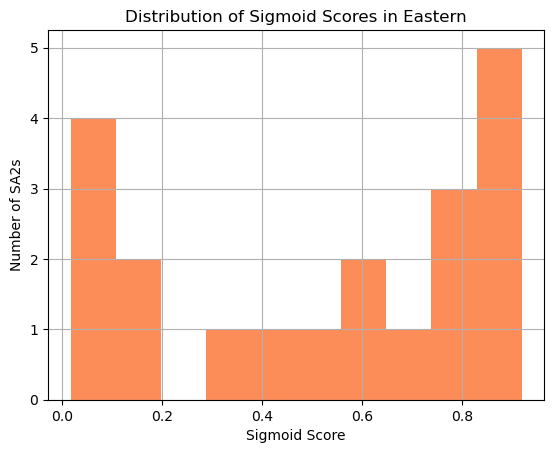

In [ ]:
'''
Histogram showing distribution of score in Eastern Suburbs
'''

sa2_scores_gdf_e['s_score'].hist(bins=10, color='#FC8D59')
plt.title("Distribution of Sigmoid Scores in Eastern")
plt.xlabel("Sigmoid Score")
plt.ylabel("Number of SA2s")
plt.savefig("e_sigmoid_distribution")
plt.show()

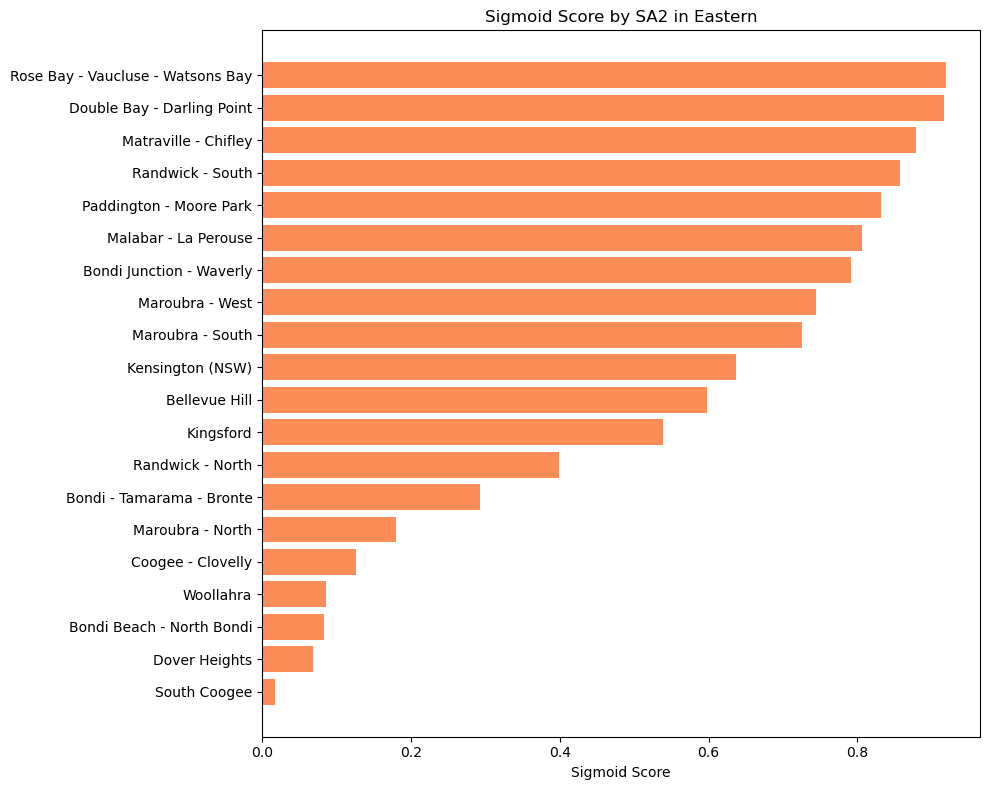

In [ ]:
'''
Bar Graph of Sigmoid Scores by SA2 in Eastern Suburbs
'''

sa2_scores_gdf_e_sorted = sa2_scores_gdf_e.sort_values('s_score', ascending=True)
plt.figure(figsize=(10, 8))
plt.barh(sa2_scores_gdf_e_sorted['sa2_name'], sa2_scores_gdf_e_sorted['s_score'], color='#FC8D59')
plt.xlabel("Sigmoid Score")
plt.title("Sigmoid Score by SA2 in Eastern")
plt.tight_layout()
plt.savefig("e_sigmoid_score")
plt.show()


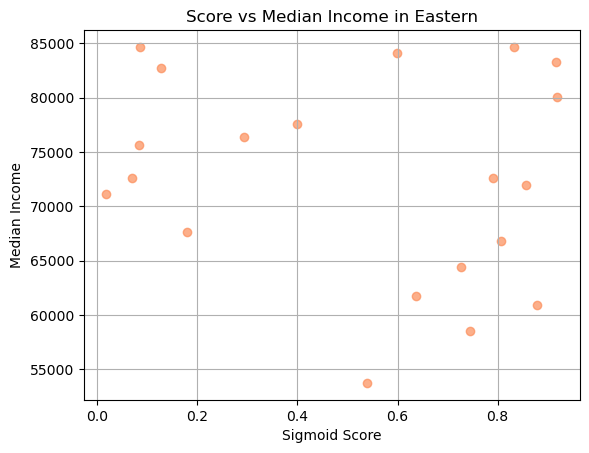

In [ ]:
'''
Scatter Plot between Sigmoid Score & Median Income in Eastern Suburb
'''

plt.scatter(sa2_scores_gdf_e['s_score'], sa2_scores_gdf_e['median_income'], color='#FC8D59', alpha=0.7)
plt.xlabel("Sigmoid Score")
plt.ylabel("Median Income")
plt.title("Score vs Median Income in Eastern")
plt.grid(True)
plt.savefig("e_score_vs_median.png")
plt.show()


In [ ]:
'''
Calculating correlation matrix between median income and scores.
'''

corr_data_e = sa2_scores_gdf_e[['median_income', 's_score', 'z_business', 'z_stops', 'z_schools', 'z_pois']]
corr_matrix_e = corr_data_e.corr()
corr_matrix_e

,median_income,s_score,z_business,z_stops,z_schools,z_pois
median_income,1.000000,-0.173237,-0.785773,0.193082,-0.005464,0.355089
s_score,-0.173237,1.000000,0.257500,0.520853,0.398185,0.650607
z_business,-0.785773,0.257500,1.000000,-0.159738,0.059474,-0.403589
z_stops,0.193082,0.520853,-0.159738,1.000000,-0.407687,0.591369
z_schools,-0.005464,0.398185,0.059474,-0.407687,1.000000,0.042067
z_pois,0.355089,0.650607,-0.403589,0.591369,0.042067,1.000000


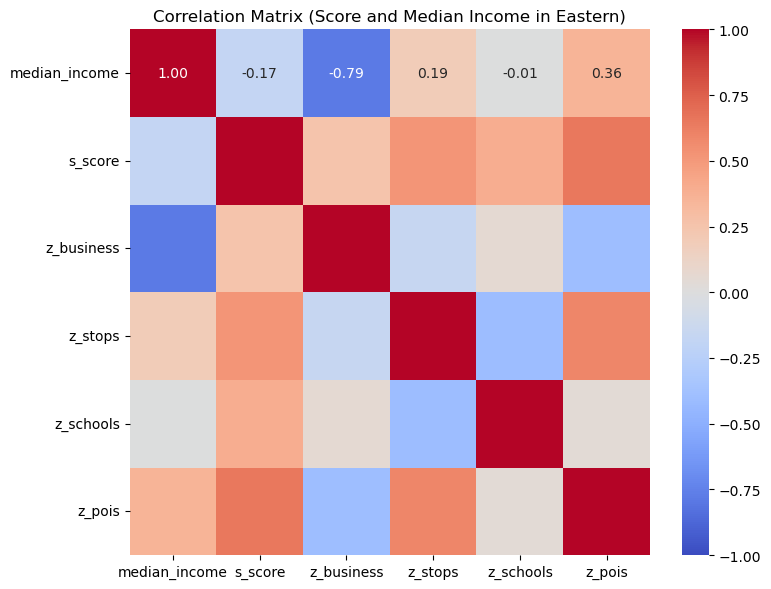

In [ ]:
'''
Correlation Heat Map: Sigmoid Score vs Median Income - Eastern Suburbs
'''

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix_e, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title("Correlation Matrix (Score and Median Income in Eastern)")
plt.tight_layout()
plt.savefig("e_corr_heatmap.png")

plt.show()

In [ ]:
'''
Compute Pearson correlation of score vs. income across all SA2s in Eastern Suburb
'''

query(conn, """
with sa2_data as (
  select
    b.sa2_code,
    s.s_score,
    i.median_income
  from sa2_boundaries b
  join sa2_scores_e s on b.sa2_code = s.sa2_code
  join income i on b.sa2_code = i.sa2_code
  where b.sa4_code = 118    -- replace 118 with your target sa4_code
)
select
  corr(s_score, median_income)       as pearson_r,
  regr_slope(s_score, median_income)    as slope,
  regr_intercept(s_score, median_income) as intercept
from sa2_data;
""")

,pearson_r,slope,intercept
0,-0.173237,-0.000006,0.969402


# SCORE CALCULATION FOR PARRAMATTA

In [ ]:
query(conn, """ 
drop materialized view if exists businesses_per_1000_p cascade;
create materialized view businesses_per_1000_p as
with sa2_parra as (select sa2_code, sa2_name from sa2_boundaries where sa4_name = 'Sydney - Parramatta'),
    bc as (select sa2_code, sa2_name, sum(total_businesses) as total_business from businesses 
    where industry_code = 'I' group by sa2_code, sa2_name)
    
SELECT
  bc.sa2_code, bc.sa2_name,
  (bc.total_business * 1000.0) / p.total_population as businesses_per_1000
FROM bc
JOIN population p ON bc.sa2_code = p.sa2_code
JOIN sa2_parra s ON bc.sa2_code = s.sa2_code
WHERE p.total_population > 100;
""")
conn.commit()
query(conn, """ select * from businesses_per_1000_p  """)

Error encountered: 
This result object does not return rows. It has been closed automatically.


,sa2_code,sa2_name,businesses_per_1000
0,125011582,Auburn - Central,31.887301
1,125011583,Auburn - North,41.370938
2,125011584,Auburn - South,22.801303
3,125011585,Berala,19.081762
4,125011586,Lidcombe,17.155714
5,125011587,Regents Park,24.409144
6,125011709,Silverwater - Newington,14.138817
7,125011710,Wentworth Point - Sydney Olympic Park,11.184816
8,125021477,Ermington - Rydalmere,10.197912
9,125021478,Oatlands - Dundas Valley,9.538180


In [ ]:
query(conn, """
drop materialized view if exists num_stops_p cascade;
create materialized view num_stops_p as
with sa2_parra as (select sa2_code, sa2_name, geom from sa2_boundaries where sa4_name = 'Sydney - Parramatta')

select s.sa2_code, s.sa2_name, count(stops.stop_id) as num_stops
from sa2_parra s
join stops on st_contains(s.geom, stops.geom)
join population p on s.sa2_code = p.sa2_code
where p.total_population > 100
group by s.sa2_code, s.sa2_name
order by count(stops.stop_id) desc
""")
conn.commit()
query(conn, """ select * from num_stops_p """)

Error encountered: 
This result object does not return rows. It has been closed automatically.


,sa2_code,sa2_name,num_stops
0,125021477,Ermington - Rydalmere,294
1,125031484,Guildford West - Merrylands West,262
2,125031479,Chester Hill - Sefton,256
3,125031713,Greystanes - South,248
4,125031483,Guildford - South Granville,242
5,125031481,Granville - Clyde,239
6,125031480,Fairfield - East,230
7,125021712,Carlingford - West,211
8,125031714,Merrylands - Holroyd,199
9,125041489,North Parramatta,198


In [ ]:
query(conn, """
drop materialized view if exists num_pois_p cascade;
create materialized view num_pois_p as 
with sa2_parra as (select sa2_code, sa2_name from sa2_boundaries where sa4_name = 'Sydney - Parramatta')

select sp.sa2_code, sp.sa2_name,
    count(*) as num_pois
    from sa2_pois sp
    join sa2_parra se on (se.sa2_code = sp.sa2_code)
    join population p ON se.sa2_code = p.sa2_code
    where p.total_population > 100
    group by sp.sa2_code, sp.sa2_name
""")
conn.commit()
query(conn, """ select * from num_pois_p """)

Error encountered: 
This result object does not return rows. It has been closed automatically.


,sa2_code,sa2_name,num_pois
0,125031713,Greystanes - South,79
1,125011585,Berala,50
2,125031481,Granville - Clyde,185
3,125041718,Parramatta - South,34
4,125041717,Parramatta - North,167
5,125011584,Auburn - South,52
6,125031480,Fairfield - East,132
7,125011586,Lidcombe,173
8,125041588,Pendle Hill - Girraween,100
9,125031484,Guildford West - Merrylands West,180


In [ ]:
query(conn, """
drop materialized view if exists schools_per_1000_p cascade;
create materialized view schools_per_1000_p as
with sa2_parra as (select sa2_code, sa2_name, geom from sa2_boundaries where sa4_name = 'Sydney - Parramatta'),
    schools_per_sa2_p as (select sa2.sa2_code, sa2.sa2_name,
            count(*) as num_schools
            from sa2_parra sa2
            join catchments ca on st_intersects(sa2.geom, ca.geom)
            group by sa2.sa2_code, sa2.sa2_name)

select sps.sa2_code, sps.sa2_name,
    (sps.num_schools * 1000.0) / p.young_population as schools_per_1000
    from schools_per_sa2_p sps
    join population p on sps.sa2_code = p.sa2_code
    where p.young_population > 100
    order by  (sps.num_schools * 1000.0) / p.young_population desc;
""")
conn.commit()

query(conn, """ select * from schools_per_1000_p """)

Error encountered: 
This result object does not return rows. It has been closed automatically.


,sa2_code,sa2_name,schools_per_1000
0,125011587,Regents Park,7.269790
1,125041717,Parramatta - North,7.102273
2,125011584,Auburn - South,5.577689
3,125041719,Rosehill - Harris Park,5.208333
4,125011585,Berala,4.975124
5,125031716,South Wentworthville,4.955401
6,125011583,Auburn - North,4.672897
7,125021711,Carlingford - East,4.608295
8,125011709,Silverwater - Newington,4.506534
9,125041490,North Rocks,4.065041


### Merge All Metrics

In [ ]:
'''
Merge all key metrics for each SA2 region in Parramatta
'''

query(conn, """
drop materialized view if exists all_metrics_p cascade;
create materialized view all_metrics_p as
    select
        b.sa2_code,
        b.sa2_name,
        b.businesses_per_1000,
        p.num_pois,
        s.num_stops,
        sc.schools_per_1000
    from businesses_per_1000_p b
    left join num_stops_p s on b.sa2_code = s.sa2_code
    left join schools_per_1000_p sc on b.sa2_code = sc.sa2_code
    left join num_pois_p p on b.sa2_code = p.sa2_code

""")
conn.commit()

query(conn, """select * from all_metrics_p""")

Error encountered: 
This result object does not return rows. It has been closed automatically.


,sa2_code,sa2_name,businesses_per_1000,num_pois,num_stops,schools_per_1000
0,125011582,Auburn - Central,31.887301,100,141,2.775850
1,125011583,Auburn - North,41.370938,59,80,4.672897
2,125011584,Auburn - South,22.801303,52,83,5.577689
3,125011585,Berala,19.081762,50,96,4.975124
4,125011586,Lidcombe,17.155714,173,181,3.938041
5,125011587,Regents Park,24.409144,44,66,7.269790
6,125011709,Silverwater - Newington,14.138817,64,80,4.506534
7,125011710,Wentworth Point - Sydney Olympic Park,11.184816,165,71,3.141690
8,125021477,Ermington - Rydalmere,10.197912,168,294,3.598299
9,125021478,Oatlands - Dundas Valley,9.538180,141,152,2.587880


In [ ]:
'''
Score Calculating for Paramatta
'''

query(conn, """
drop materialized view if exists sa2_scores_p;
create materialized view sa2_scores_p as
with stats as (
  select 
    *,
    avg(businesses_per_1000) over () as avg_biz,
    stddev_pop(businesses_per_1000) over () as std_biz,
    
    avg(num_stops) over () as avg_stops,
    stddev_pop(num_stops) over () as std_stops,

    avg(num_pois) over () as avg_pois,
    stddev_pop(num_pois) over () as std_pois,

    avg(schools_per_1000) over () as avg_schools,
    stddev_pop(schools_per_1000) over () as std_schools
  from all_metrics_p
)

select
  sa2_code,
  sa2_name,
  businesses_per_1000,
  num_pois,
  num_stops,
  schools_per_1000,

  -- z-scores
  (businesses_per_1000 - avg_biz) / std_biz as z_business,
  (num_stops - avg_stops) / std_stops as z_stops,
  (num_pois - avg_pois) / std_pois as z_pois,
  (schools_per_1000 - avg_schools) / std_schools as z_schools,

  -- s score (sigmoid of total z-score)
  1.0 / (1 + exp(-(
    ((businesses_per_1000 - avg_biz) / std_biz) +
    ((num_stops - avg_stops) / std_stops) +
    ((num_pois - avg_pois) / std_pois) +
    ((schools_per_1000 - avg_schools) / std_schools)
  ))) as s_score

from stats;
""")
conn.commit()

query(conn, """select * from sa2_scores_p order by s_score desc""")

Error encountered: 
This result object does not return rows. It has been closed automatically.


,sa2_code,sa2_name,businesses_per_1000,num_pois,num_stops,schools_per_1000,z_business,z_stops,z_pois,z_schools,s_score
0,125031481,Granville - Clyde,25.476892,185,239,3.299120,1.007516,1.234396,1.081511,-0.289826,0.954069
1,125041719,Rosehill - Harris Park,33.004386,134,59,5.208333,1.938641,-1.339569,0.144083,1.116391,0.865244
2,125021477,Ermington - Rydalmere,10.197912,168,294,3.598299,-0.882441,2.020885,0.769035,-0.069468,0.862713
3,125041717,Parramatta - North,16.389412,167,60,7.102273,-0.116574,-1.325269,0.750654,2.511359,0.860587
4,125041489,North Parramatta,13.307326,213,198,3.702942,-0.497817,0.648104,1.596178,0.007606,0.852465
5,125011586,Lidcombe,17.155714,173,181,3.938041,-0.021785,0.405007,0.860940,0.180767,0.806110
6,125011583,Auburn - North,41.370938,59,80,4.672897,2.973554,-1.039273,-1.234488,0.722020,0.805622
7,125031484,Guildford West - Merrylands West,16.433143,180,262,2.098951,-0.111165,1.563292,0.989606,-1.173803,0.780388
8,125041491,Northmead,14.738285,247,103,3.550543,-0.320813,-0.710377,2.221130,-0.104642,0.747495
9,125031483,Guildford - South Granville,19.817344,144,242,2.254156,0.307449,1.277296,0.327892,-1.059487,0.701228


### Visualization for Parramatta

In [ ]:
'''
Creating GeoDataFrame to retrieve SA2-level score components and geometry for Parramatta
'''

sa2_scores_gdf_p = gpd.read_postgis("""
    select 
        p.sa2_code, 
        p.sa2_name,
        p.z_business,
        p.z_stops,
        p.z_pois,
        p.z_schools,
        p.s_score, 
        b.geom,
        i.median_income
    from sa2_scores_p p 
    join sa2_boundaries b on p.sa2_code = b.sa2_code
    join income i on p.sa2_code = i.sa2_code
""", conn, geom_col='geom')

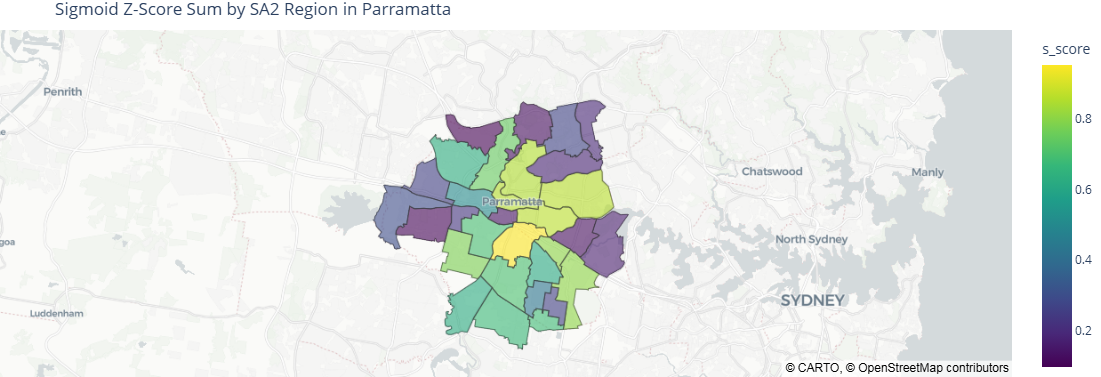

In [ ]:
'''
c'''

sa2_scores_gdf_p = sa2_scores_gdf_p.to_crs(epsg=4326) # Convert geometry to WGS84

geojson = sa2_scores_gdf_p.__geo_interface__ # Convert to GeoJSON

fig = px.choropleth_map(
    sa2_scores_gdf_p,
    geojson=geojson,
    locations='sa2_code',
    color='s_score',
    featureidkey='properties.sa2_code',
    hover_name='sa2_name',
    color_continuous_scale='Viridis',
    map_style='carto-positron',
    zoom=10,
    center={"lat": -33.816, "lon": 151.0},
    opacity=0.6,
    title='Sigmoid Z-Score Sum by SA2 Region in Parramatta'
)

fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(margin={"r":0,"t":30,"l":0,"b":0})

fig.show()


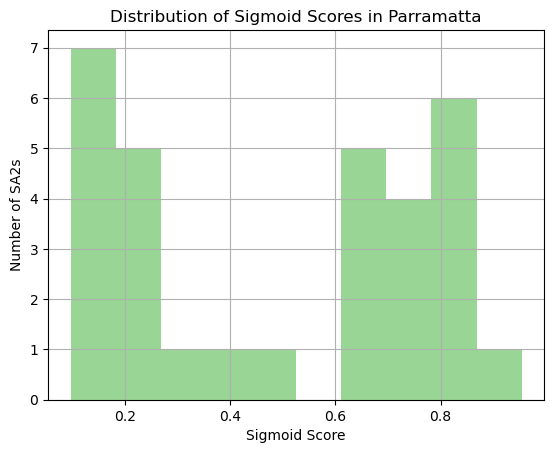

In [ ]:
'''
Histogram showing distribution of score in Parramatta
'''

sa2_scores_gdf_p['s_score'].hist(bins=10, color='#99d594')
plt.title("Distribution of Sigmoid Scores in Parramatta")
plt.xlabel("Sigmoid Score")
plt.ylabel("Number of SA2s")
plt.savefig("p_sigmoid_distribution.png")
plt.show()

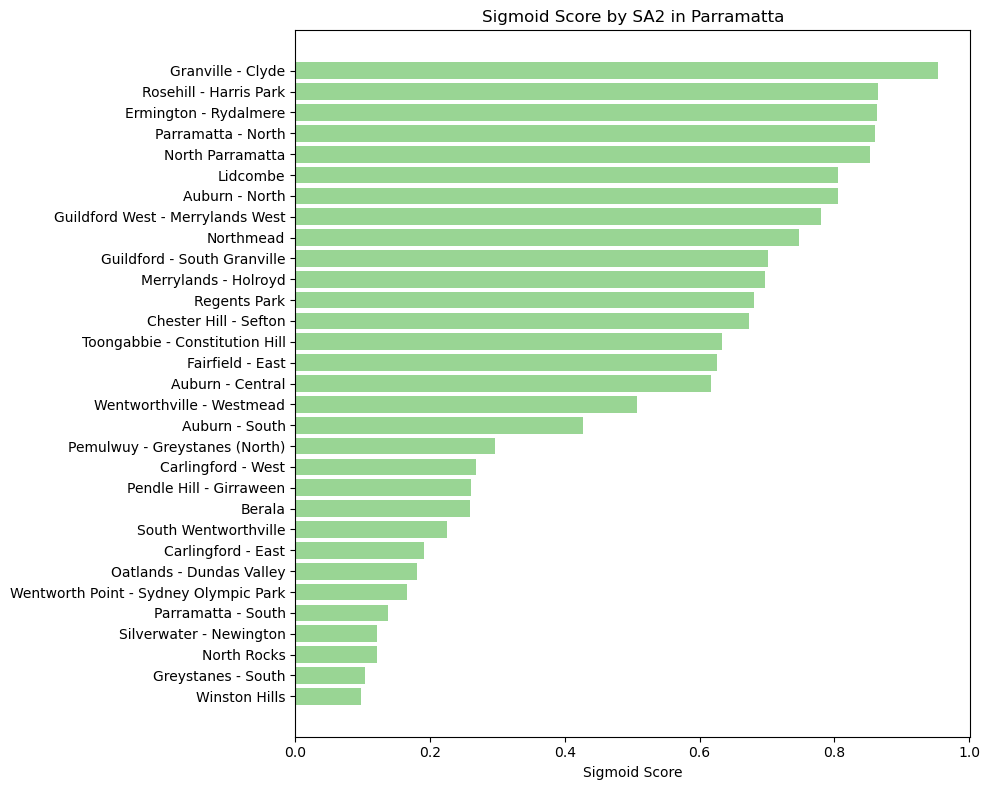

In [ ]:
'''
Bar Graph of Sigmoid Scores by SA2 in Parramatta
'''

sa2_scores_gdf_p_sorted = sa2_scores_gdf_p.sort_values('s_score', ascending=True)
plt.figure(figsize=(10, 8))
plt.barh(sa2_scores_gdf_p_sorted['sa2_name'], sa2_scores_gdf_p_sorted['s_score'], color='#99d594')
plt.xlabel("Sigmoid Score")
plt.title("Sigmoid Score by SA2 in Parramatta")
plt.tight_layout()
plt.savefig("p_sigmoid_score.png")
plt.show()


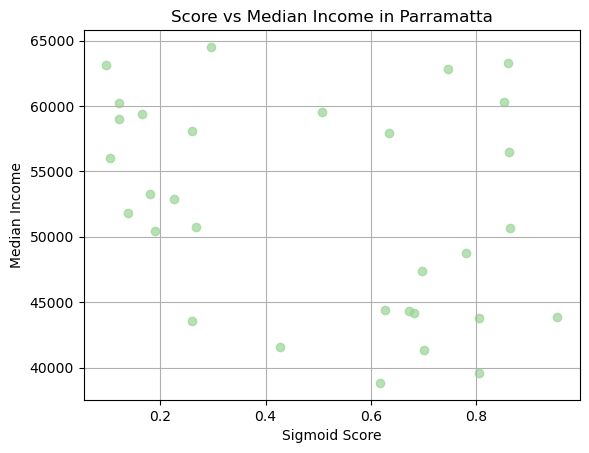

In [ ]:
'''
Scatter Plot between Sigmoid Score & Median Income in Parramatta
'''

plt.scatter(sa2_scores_gdf_p['s_score'], sa2_scores_gdf_p['median_income'], color='#99d594', alpha=0.7)
plt.xlabel("Sigmoid Score")
plt.ylabel("Median Income")
plt.title("Score vs Median Income in Parramatta")
plt.grid(True)
plt.savefig("p_score_vs_median.png")
plt.show()


In [ ]:
'''
Calculating correlation matrix between median income and scores.
'''

corr_data_p = sa2_scores_gdf_p[['median_income', 's_score', 'z_business', 'z_stops', 'z_schools', 'z_pois']]
corr_matrix_p = corr_data_p.corr()
corr_matrix_p

,median_income,s_score,z_business,z_stops,z_schools,z_pois
median_income,1.000000,-0.326618,-0.613496,-0.159143,-0.028892,0.321015
s_score,-0.326618,1.000000,0.469729,0.295623,0.139717,0.542605
z_business,-0.613496,0.469729,1.000000,-0.309590,0.277567,-0.276282
z_stops,-0.159143,0.295623,-0.309590,1.000000,-0.691827,0.422921
z_schools,-0.028892,0.139717,0.277567,-0.691827,1.000000,-0.358654
z_pois,0.321015,0.542605,-0.276282,0.422921,-0.358654,1.000000


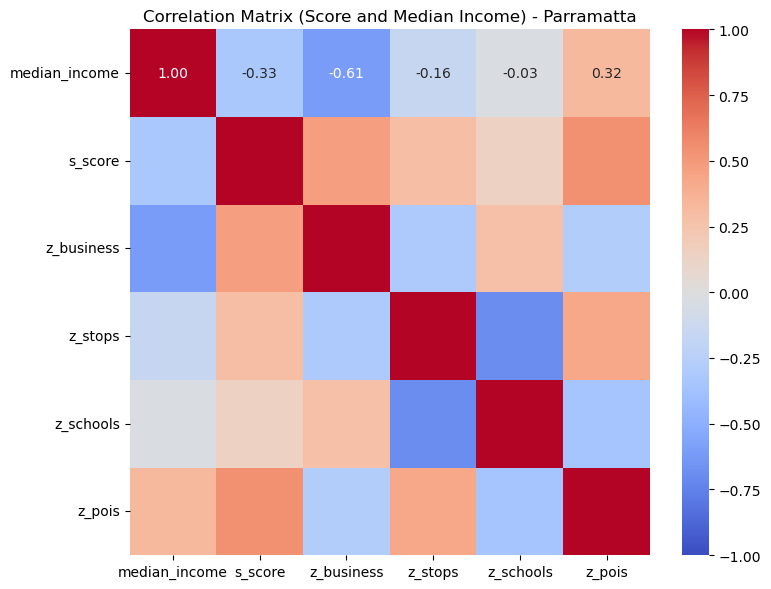

In [ ]:
'''
Correlation Heat Map: Sigmoid Score vs Median Income - Parramatta
'''

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix_p, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title("Correlation Matrix (Score and Median Income) - Parramatta")
plt.tight_layout()
plt.savefig("p_corr_heatmap.png")
plt.show()

In [ ]:
'''
Compute Pearson correlation of score vs. income across all SA2s in Parramatta
'''

query(conn, """
with sa2_data_p as (
  select
    b.sa2_code,
    s.s_score,
    i.median_income
  from sa2_boundaries b
  join sa2_scores_p s on b.sa2_code = s.sa2_code
  join income i on b.sa2_code = i.sa2_code
  where b.sa4_code = 125
)
select
  corr(s_score, median_income)       as pearson_r,
  regr_slope(s_score, median_income)    as slope,
  regr_intercept(s_score, median_income) as intercept
from sa2_data_p;
""")

,pearson_r,slope,intercept
0,-0.326618,-0.000012,1.12602


# ADVANCE SCORE CALCULATION

In [ ]:
'''
Rank-score Calculation for Eastern Suburbs
'''

query(conn, """
DROP MATERIALIZED VIEW IF EXISTS ranked_metrics_e CASCADE;
CREATE MATERIALIZED VIEW ranked_metrics_e AS
WITH ranked AS (
    SELECT
        *,
        RANK() OVER (ORDER BY businesses_per_1000 DESC) AS r_business,
        RANK() OVER (ORDER BY num_pois DESC) AS r_poi,
        RANK() OVER (ORDER BY num_stops DESC) AS r_stops,
        RANK() OVER (ORDER BY schools_per_1000 DESC) AS r_schools
    FROM all_metrics_e
),
scored AS (
    SELECT *,
        (r_business + r_poi + r_stops + r_schools) / 4.0 AS avg_rank
    FROM ranked
)
SELECT sa2_code, sa2_name, r_business, r_poi, r_stops, r_schools, avg_rank,
    1 - 
    (avg_rank - MIN(avg_rank) OVER ()) / NULLIF(MAX(avg_rank) OVER () - MIN(avg_rank) OVER (), 0) AS r_score
FROM scored;

""")
conn.commit()
query(conn, "SELECT * FROM ranked_metrics_e ORDER BY r_score DESC")


Error encountered: 
This result object does not return rows. It has been closed automatically.


,sa2_code,sa2_name,r_business,r_poi,r_stops,r_schools,avg_rank,r_score
0,118011650,Double Bay - Darling Point,8,4,15,1,7.00,1.000000
1,118021653,Matraville - Chifley,1,8,4,15,7.00,1.000000
2,118021570,Randwick - South,14,5,4,6,7.25,0.975610
3,118011341,Bondi Junction - Waverly,13,7,3,7,7.50,0.951220
4,118011345,Paddington - Moore Park,19,3,11,2,8.75,0.829268
5,118021567,Maroubra - South,4,16,7,8,8.75,0.829268
6,118021652,Malabar - La Perouse,15,2,6,13,9.00,0.804878
7,118021564,Kensington (NSW),5,12,16,3,9.00,0.804878
8,118011649,Bellevue Hill,12,6,2,16,9.00,0.804878
9,118011346,Rose Bay - Vaucluse - Watsons Bay,17,1,1,19,9.50,0.756098


In [ ]:
'''
Rank-score Calculation for Parramatta
'''

query(conn, """
DROP MATERIALIZED VIEW IF EXISTS ranked_metrics_p CASCADE;
CREATE MATERIALIZED VIEW ranked_metrics_p AS
WITH ranked AS (
    SELECT
        *,
        RANK() OVER (ORDER BY businesses_per_1000 DESC) AS r_business,
        RANK() OVER (ORDER BY num_pois DESC) AS r_poi,
        RANK() OVER (ORDER BY num_stops DESC) AS r_stops,
        RANK() OVER (ORDER BY schools_per_1000 DESC) AS r_schools
    FROM all_metrics_p
),
scored AS (
    SELECT *,
        (r_business + r_poi + r_stops + r_schools) / 4.0 AS avg_rank
    FROM ranked
)
SELECT sa2_code, sa2_name, r_business, r_poi, r_stops, r_schools, avg_rank,
    1 - 
    (avg_rank - MIN(avg_rank) OVER ()) / NULLIF(MAX(avg_rank) OVER () - MIN(avg_rank) OVER (), 0) AS r_score
FROM scored;

""")
conn.commit()
query(conn, "SELECT * FROM ranked_metrics_p ORDER BY r_score DESC")


Error encountered: 
This result object does not return rows. It has been closed automatically.


,sa2_code,sa2_name,r_business,r_poi,r_stops,r_schools,avg_rank,r_score
0,125031481,Granville - Clyde,5,3,6,17,7.75,1.000000
1,125011586,Lidcombe,13,7,12,11,10.75,0.793103
2,125041489,North Parramatta,21,2,10,13,11.50,0.741379
3,125031484,Guildford West - Merrylands West,14,4,2,29,12.25,0.689655
4,125021477,Ermington - Rydalmere,25,8,1,15,12.25,0.689655
5,125041719,Rosehill - Harris Park,2,15,30,4,12.75,0.655172
6,125031714,Merrylands - Holroyd,9,6,9,30,13.50,0.603448
7,125031483,Guildford - South Granville,10,13,5,28,14.00,0.568966
8,125041717,Parramatta - North,15,10,29,2,14.00,0.568966
9,125041491,Northmead,19,1,21,16,14.25,0.551724


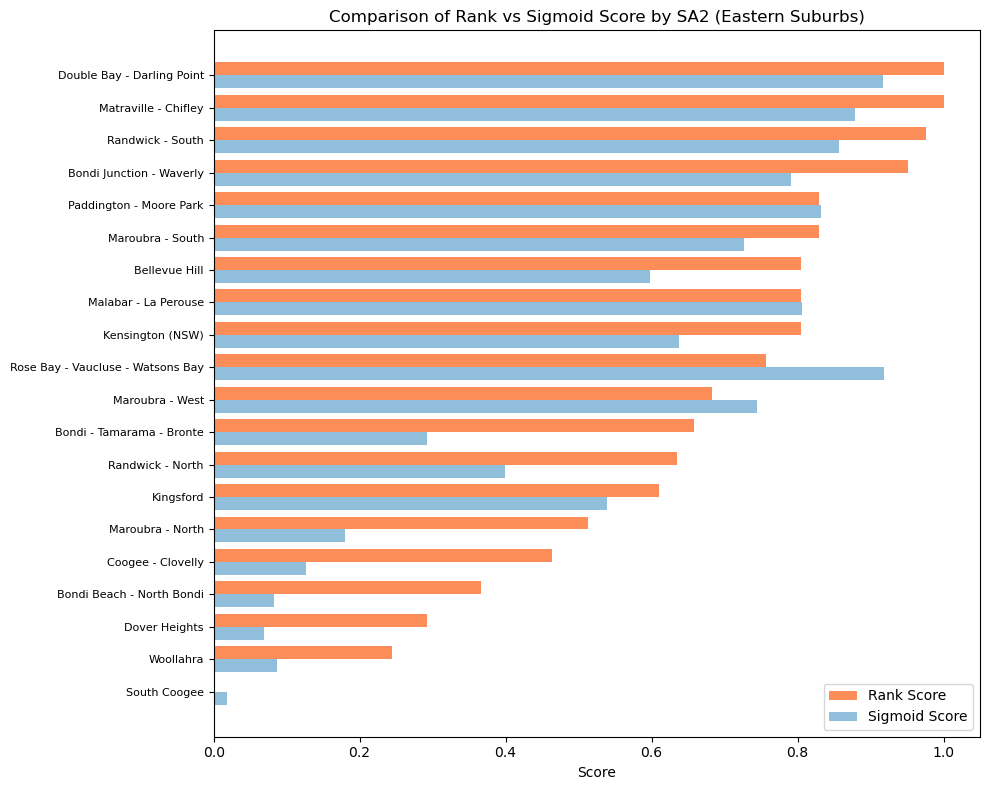

In [ ]:
'''
Bar Graph for rank score by SA2 in Eastern Suburbs
'''

e_ranked = pd.read_sql("select * from ranked_metrics_e order by r_score desc", conn)
e_ranked.sort_values("r_score", ascending = True, inplace = True)
combined_scores_e = pd.merge(
    e_ranked[['sa2_name', 'r_score']],
    sa2_scores_gdf_e[['sa2_name', 's_score']],
    on='sa2_name'
)

combined_scores_e.sort_values('r_score', ascending=True, inplace=True)
fig, ax = plt.subplots(figsize=(10, 8))

y = np.arange(len(combined_scores_e))
bar_width = 0.4

ax.barh(y + bar_width/2, combined_scores_e['r_score'], height=bar_width, label='Rank Score', color='#FC8D59')
ax.barh(y - bar_width/2, combined_scores_e['s_score'], height=bar_width, label='Sigmoid Score', color='#91BFDB')

ax.set_yticks(y)
ax.set_yticklabels(combined_scores_e['sa2_name'], fontsize=8)
ax.set_xlabel("Score")
ax.set_title("Comparison of Rank vs Sigmoid Score by SA2 (Eastern Suburbs)")
ax.legend()

plt.tight_layout()
plt.savefig("e_score_comparison.png")
plt.show()

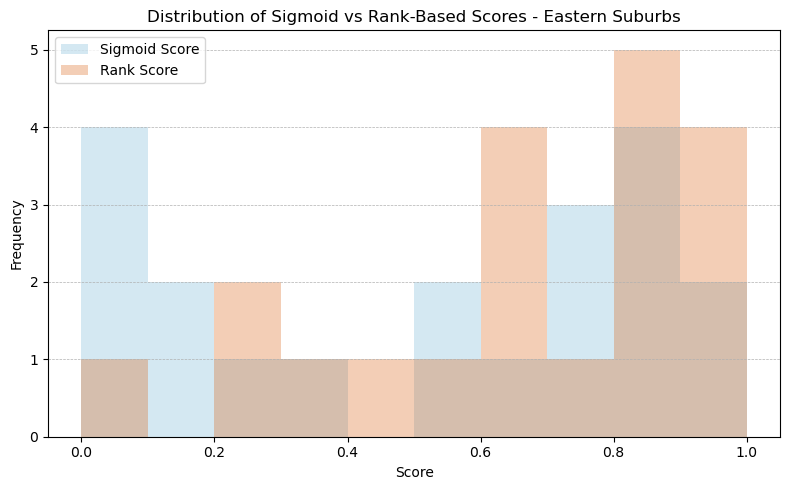

In [ ]:
'''
Histogram showing Distribution of Sigmoid Score vs Rank-based Scores in Eastern Suburbs
'''
plt.figure(figsize=(8, 5))
bins = np.linspace(0, 1, 11)

plt.hist(combined_scores_e['s_score'], bins=bins, alpha=0.2, label='Sigmoid Score',
         color="#2b8cbe", linewidth=0.5)

plt.hist(combined_scores_e['r_score'], bins=bins, alpha=0.3, label='Rank Score',
         color="#d95f0e", linewidth=0.5)

plt.xlabel("Score")
plt.ylabel("Frequency")
plt.title("Distribution of Sigmoid vs Rank-Based Scores - Eastern Suburbs")
plt.legend()
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig("e_score_distribution_histogram.png")
plt.show()


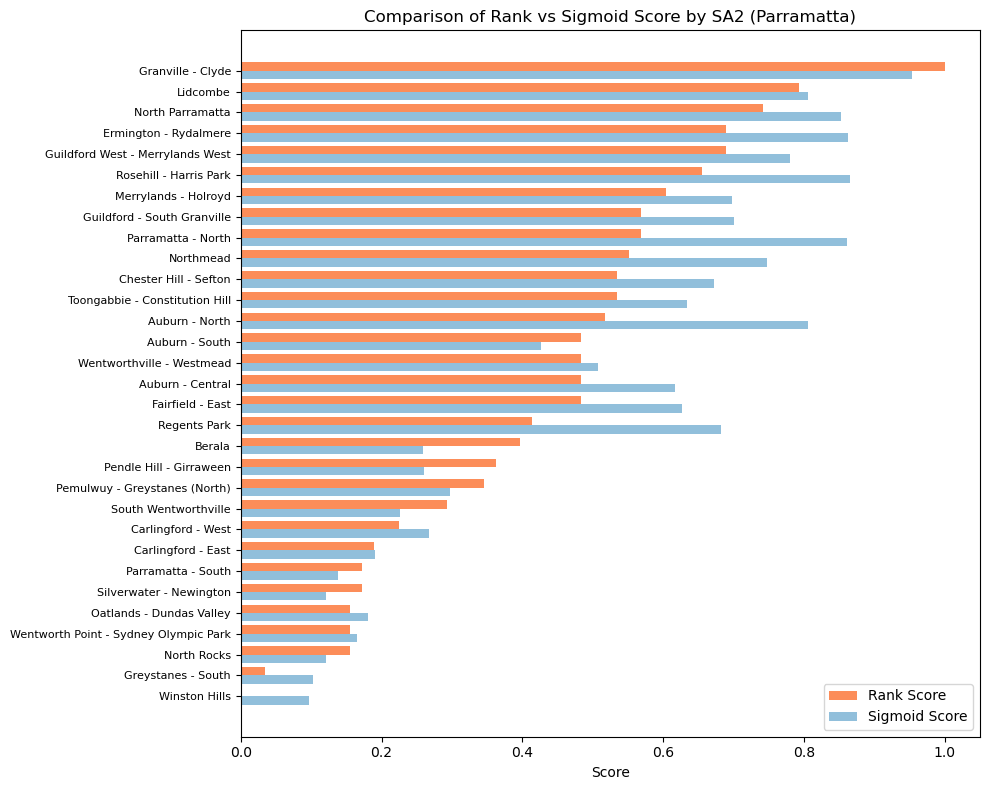

In [ ]:
'''
Bar Graph for rank score by SA2 in Parramatta
'''

p_ranked = pd.read_sql("select * from ranked_metrics_p", conn)
p_ranked.sort_values("r_score", ascending = True, inplace = True)
combined_scores_p = pd.merge(
    p_ranked[['sa2_name', 'r_score']],
    sa2_scores_gdf_p[['sa2_name', 's_score']],
    on='sa2_name'
)

combined_scores_p.sort_values('r_score', ascending=True, inplace=True)
fig, ax = plt.subplots(figsize=(10, 8))

y = np.arange(len(combined_scores_p))
bar_width = 0.4

ax.barh(y + bar_width/2, combined_scores_p['r_score'], height=bar_width, label='Rank Score', color='#FC8D59')
ax.barh(y - bar_width/2, combined_scores_p['s_score'], height=bar_width, label='Sigmoid Score', color='#91BFDB')

ax.set_yticks(y)
ax.set_yticklabels(combined_scores_p['sa2_name'], fontsize=8)
ax.set_xlabel("Score")
ax.set_title("Comparison of Rank vs Sigmoid Score by SA2 (Parramatta)")
ax.legend()

plt.tight_layout()
plt.savefig("p_score_comparison.png")
plt.show()


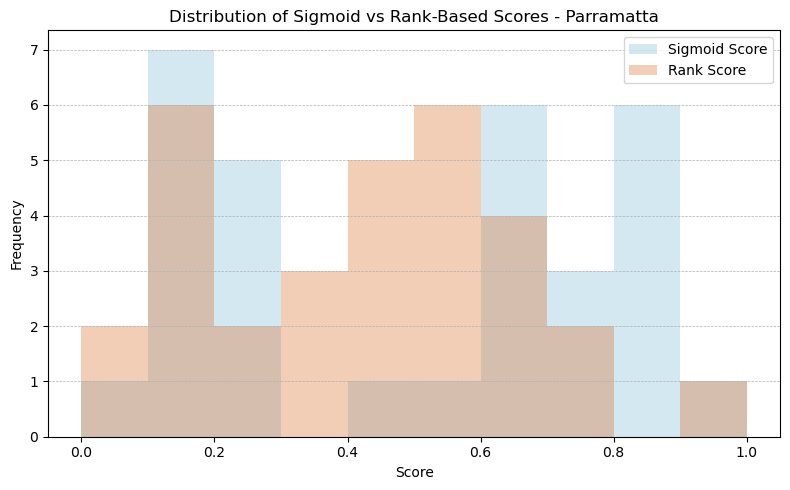

In [ ]:
'''
Histogram showing Distribution of Sigmoid Score vs Rank-based Scores in Parramatta
'''

plt.figure(figsize=(8, 5))
bins = np.linspace(0, 1, 11)

plt.hist(combined_scores_p['s_score'], bins=bins, alpha=0.2, label='Sigmoid Score',
         color="#2b8cbe", linewidth=0.5)

plt.hist(combined_scores_p['r_score'], bins=bins, alpha=0.3, label='Rank Score',
         color="#d95f0e", linewidth=0.5)

plt.xlabel("Score")
plt.ylabel("Frequency")
plt.title("Distribution of Sigmoid vs Rank-Based Scores - Parramatta")
plt.legend()
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig("p_score_distribution_histogram.png")
plt.show()


# BUILDING REGRESSION MODEL

In [ ]:
'''
Merging all metrics from both SA4.
'''

sql = """
WITH sa2_parramatta_eastern AS (
    SELECT sa2_code, sa2_name, areasqkm21
    FROM sa2_boundaries 
    WHERE sa4_code = 125 OR sa4_code = 118
),
business_agg AS (
    SELECT sa2_code, SUM(total_businesses) AS total_businesses
    FROM businesses
    WHERE industry_code IN ('I')  -- change or expand as needed
    GROUP BY sa2_code
),
stop_counts AS (
    SELECT sb.sa2_code, COUNT(*) AS num_stops
    FROM stops s
    JOIN sa2_boundaries sb ON ST_Contains(sb.geom, s.geom)
    GROUP BY sb.sa2_code
),
poi_counts AS (
    SELECT sa2_code, COUNT(*) AS num_pois
    FROM sa2_pois
    GROUP BY sa2_code
),
catchment_counts AS (
    SELECT sb.sa2_code, COUNT(*) AS num_catchments
    FROM catchments c
    JOIN sa2_boundaries sb ON ST_Intersects(c.geom, sb.geom)
    GROUP BY sb.sa2_code
)

SELECT
    sb.sa2_code,
    sb.sa2_name,
    i.median_income,
    p.total_population,
    p.young_population,
    sb.areasqkm21,

    COALESCE(b.total_businesses, 0) * 1000.0 / NULLIF(p.total_population, 0) AS businesses_per_1000,
    COALESCE(s.num_stops, 0) AS num_stops,
    COALESCE(pc.num_pois, 0) AS num_pois,
    COALESCE(c.num_catchments, 0) * 1000.0 / NULLIF(p.young_population, 0) AS catchments_per_1000_youth

FROM sa2_parramatta_eastern sb
JOIN population p ON sb.sa2_code = p.sa2_code
JOIN income i ON sb.sa2_code = i.sa2_code
JOIN business_agg b ON sb.sa2_code = b.sa2_code
JOIN stop_counts s ON sb.sa2_code = s.sa2_code
JOIN poi_counts pc ON sb.sa2_code = pc.sa2_code
JOIN catchment_counts c ON sb.sa2_code = c.sa2_code

WHERE p.total_population > 100 
"""

# Execute query and load into DataFrame
df = pd.read_sql(sql, con=conn)
df


,sa2_code,sa2_name,median_income,total_population,young_population,areasqkm21,businesses_per_1000,num_stops,num_pois,catchments_per_1000_youth
0,118011339,Bondi - Tamarama - Bronte,76417.0,19297,3686,2.4962,4.456651,102,80,3.255562
1,118011340,Bondi Beach - North Bondi,75695.0,21041,3921,2.4604,4.039732,96,78,1.530222
2,118011341,Bondi Junction - Waverly,72603.0,17866,3412,2.5235,3.806112,144,106,4.689332
3,118011344,Dover Heights,72627.0,11184,2856,1.8705,4.828326,84,55,1.750700
4,118011345,Paddington - Moore Park,84655.0,14927,2484,3.7250,2.545723,101,177,6.038647
5,118011346,Rose Bay - Vaucluse - Watsons Bay,80031.0,12027,3004,5.1368,2.660680,191,233,1.664447
6,118011347,Woollahra,84677.0,7486,1477,1.2805,2.404488,53,59,5.416385
7,118011649,Bellevue Hill,84072.0,14516,3188,3.1556,3.857812,159,117,2.195734
8,118011650,Double Bay - Darling Point,83322.0,10046,1474,1.5591,4.678479,74,174,6.784261
9,118021564,Kensington (NSW),61742.0,11975,2242,2.6423,6.012526,73,70,5.798394


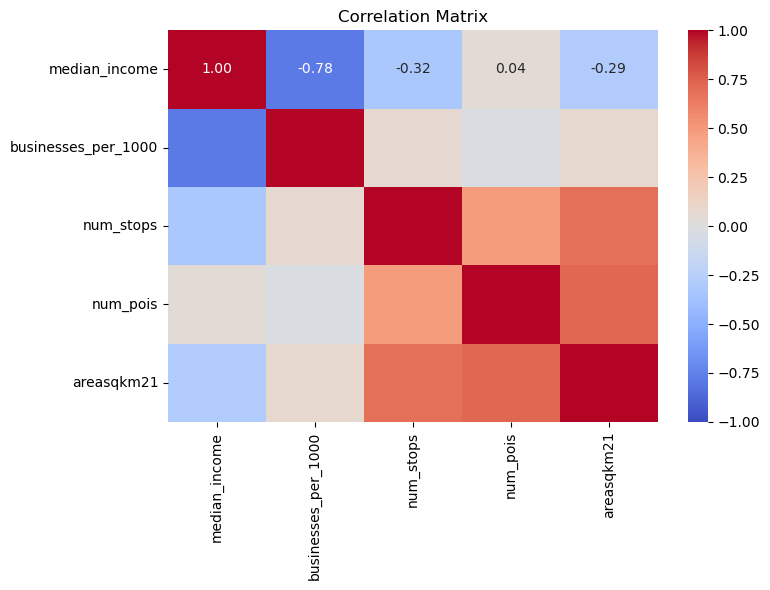

In [ ]:
'''
Choosing variable of interest
'''
corr_features = [
    'median_income',
    'businesses_per_1000',
    'num_stops',
    'num_pois',
    'areasqkm21',
]

corr_matrix = df[corr_features].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1, annot=True)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

### Regression Model

In [ ]:
def backward_selected(data, response, nominated = []):
    """Linear model designed by backward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by backward selection
           evaluated by adjusted R-squared
    """
    remaining = set(data.columns)
    remaining.remove(response)
    if nominated:
        print("you nominated variables %s" %nominated)
    nominated = set(nominated)
    remaining^=nominated
    formula = "{} ~ {} + 1".format(response,' + '.join(remaining | nominated))
    current_score = smf.ols(formula, data).fit().rsquared_adj
    print("adj_r2 if all variables included: %f" %current_score)
    best_new_score = current_score
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(remaining^{candidate}|nominated))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            print("deleting %s increases adj_r2 from %f to %f" %(best_candidate, current_score, best_new_score))
            remaining.remove(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(remaining|nominated))
    model = smf.ols(formula, data).fit()
    print("final model is %s, with adj_r2 of %f" %(formula, model.rsquared_adj))
    return model

In [ ]:
'''
Splits data into train and test sets (80/20), 
performs backward feature selection to predict median income, 
and evaluates model using R² and RMSE.
'''

import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from patsy import dmatrices

X = df[['median_income', 'businesses_per_1000', 'num_pois', 'num_stops', 'areasqkm21']]

train_df, test_df = train_test_split(X, test_size=0.2, random_state=42)

final_model = backward_selected(train_df, response='median_income')

# Extracts the correct predictors from the model's formula
_, X_test_design = dmatrices(final_model.model.formula, data=test_df, return_type='dataframe')

# Extract target and make predictions
y_test = test_df['median_income']
y_pred = final_model.predict(X_test_design)
print(final_model.summary())

print("Test R²:", r2_score(y_test, y_pred))
print("Test RMSE:", mean_squared_error(y_test, y_pred, squared=False))


adj_r2 if all variables included: 0.776008
final model is median_income ~ num_stops + num_pois + businesses_per_1000 + areasqkm21 + 1, with adj_r2 of 0.776008
                            OLS Regression Results                            
Dep. Variable:          median_income   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     34.78
Date:                Sun, 18 May 2025   Prob (F-statistic):           9.60e-12
Time:                        18:54:51   Log-Likelihood:                -406.22
No. Observations:                  40   AIC:                             822.4
Df Residuals:                      35   BIC:                             830.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                          coef    std err          

### Assumptions Checking

In [ ]:
'''
Using VIF to test for multicollinerality
'''

from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

X = df[['businesses_per_1000', 'num_pois', 'num_stops', 'areasqkm21']]
X = sm.add_constant(X)

vif = pd.DataFrame()
vif["Feature"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif


,Feature,VIF
0,const,8.727391
1,businesses_per_1000,1.019778
2,num_pois,2.137954
3,num_stops,1.892515
4,areasqkm21,3.083768


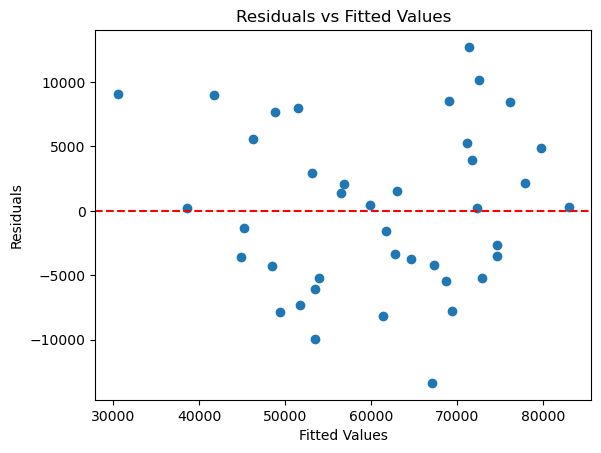

In [ ]:
'''
Using Residual Plots to check for linearity & homoskedasticity
'''
fitted_vals = final_model.fittedvalues
residuals = final_model.resid

plt.scatter(fitted_vals, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted Values")
plt.show()


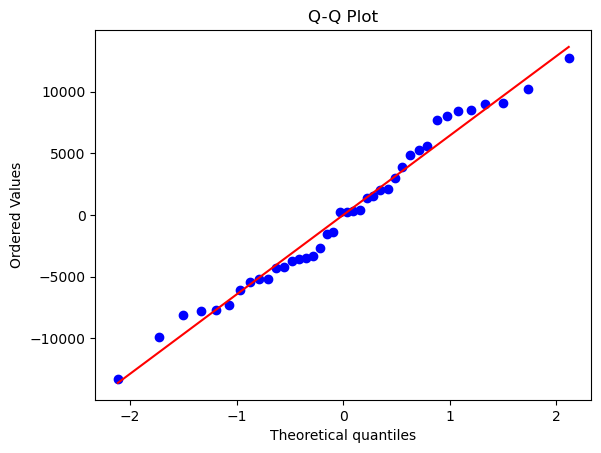

In [ ]:
'''
Using Q-Q Plot to check for normality assumption
'''

import scipy.stats as stats
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot")
plt.show()
